In [1]:

from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from utils.utils_embedding import evaluate, dataframe_results, plot_embeddings, create_set_embeddings, load_qa_dataset
from sklearn.decomposition import PCA
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

/opt/homebrew/Caskroom/miniconda/base/envs/agent/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Settings

In [2]:
# load dataset QA
dataset_name = "QA/gpt-35-turbo_dataset.json"
# results top-k
top_k = 5
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

# Load QA synthetic dataset

In [3]:
it_dataset = load_qa_dataset(dataset_name)

2025-07-14 18:11:06.908 | INFO     | utils.utils_embedding:load_qa_dataset:15 - Loading dataset from QA/gpt-35-turbo_dataset.json


# View QA dataset sample

In [4]:
print(it_dataset.queries["6c67a361-1d84-4876-8ed5-72e11dd2f21e"])
print(it_dataset.relevant_docs["6c67a361-1d84-4876-8ed5-72e11dd2f21e"])
print(it_dataset.corpus["80b9998c-32d4-42f7-94a7-1a36155b382b"])

Qual è la data del documento di lavoro dei servizi della Commissione Europea sulla relazione per paese 2025 dell'Italia?
['80b9998c-32d4-42f7-94a7-1a36155b382b']
IT   IT 
 
 
 COMMISSIONE  
EUROPEA   
Bruxelles, 4.6.2025  
SWD(2025) 212 final  
 
DOCUMENTO DI LAVORO DEI SERVIZI DELLA COMMISSIONE  
Relazione per paese 2025 - Italia  
che accompagna il documento  
Raccomandazione di RACCOMANDAZIONE DEL CONSIGLIO  
sulle politiche economiche, sociali, occupazionali, strutturali e di bilancio dell'Italia  
{COM(2025)  212 final}


# HuggingFace: paraphrase-multilingual-MiniLM-L12-v2

In [5]:
embed_model_paraphrase_l12 = HuggingFaceEmbedding(model_name=model_name)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


# Evaluate with is_hit and mrr


In [6]:
df_paraphrase_l12_results_it = evaluate(dataset=it_dataset, 
                                        embed_model=embed_model_paraphrase_l12, 
                                        top_k=top_k, 
                                        verbose=True)
print(len(df_paraphrase_l12_results_it))
df_paraphrase_l12_results_it.head()

Some nodes are missing content, skipping them...


100%|██████████| 260/260 [00:04<00:00, 61.29it/s]

260


,is_hit,mrr,retrieved,expected,query
0,True,1.0,"[80b9998c-32d4-42f7-94a7-1a36155b382b, ca82b43...",80b9998c-32d4-42f7-94a7-1a36155b382b,6c67a361-1d84-4876-8ed5-72e11dd2f21e
1,False,0.0,"[e81fb935-4ea8-4a80-867d-ed15f40d0a0c, 0ddb84a...",93b772d4-52a6-44a6-a331-0eae1fdf33a5,5377179f-f310-4498-9a81-4a644d21eef6
2,True,1.0,"[f612986a-0b1a-4c12-bdf1-2c2107733db7, f1b6e8e...",f612986a-0b1a-4c12-bdf1-2c2107733db7,a980095d-5cd4-4112-9b80-d3d1e7023f44
3,True,1.0,"[b87e8ec1-9380-48ad-9428-47c47ede0e76, c0f6569...",b87e8ec1-9380-48ad-9428-47c47ede0e76,364684a1-eafa-4081-ba35-bb669d1657b7
4,True,0.5,"[e96386a3-3796-457d-875e-2d6c7bdab02f, 4a5026b...",4a5026bd-2856-497f-8276-9de39b7562e6,2356fbfa-7df2-467d-ac72-ef26ed474fff


# perform PCA

In [7]:
# collect embeddings for the dataset corpus
array_embeddings_paraphrase_l12_it = create_set_embeddings(it_dataset, embed_model_paraphrase_l12)

# init PCA and project the embeddings to 2D for visualization
pca = PCA(n_components=2)
projected = pca.fit_transform(array_embeddings_paraphrase_l12_it)

100%|██████████| 260/260 [00:03<00:00, 66.53it/s]


# retrieve with expected not in top-k

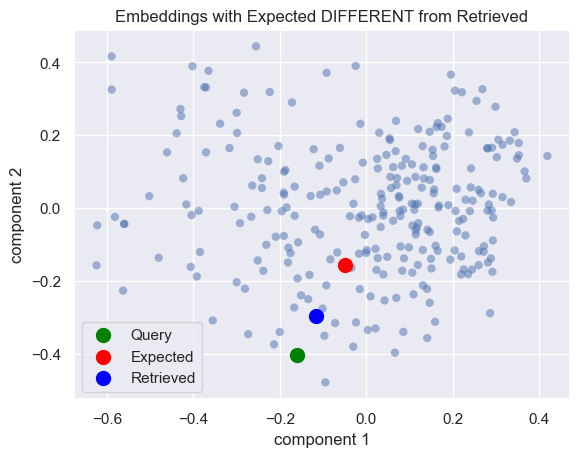

In [8]:
query_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.queries["5377179f-f310-4498-9a81-4a644d21eef6"])
expected_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.corpus["93b772d4-52a6-44a6-a331-0eae1fdf33a5"])
retrieved_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.corpus["e81fb935-4ea8-4a80-867d-ed15f40d0a0c"])

plot_embeddings(pca, projected, query_embedding, expected_embedding, retrieved_embedding)

# retrieve with expect in top-k

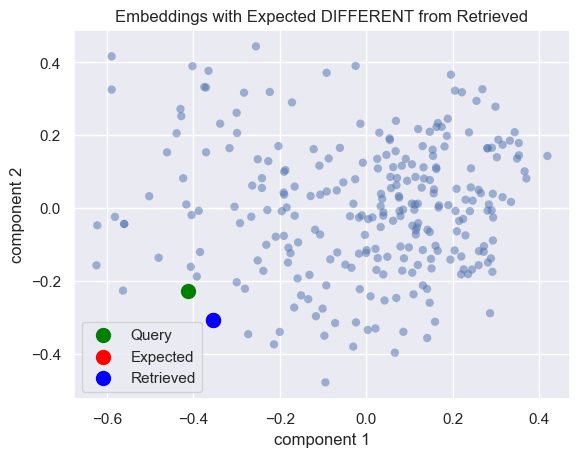

In [9]:
query_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.queries["6c67a361-1d84-4876-8ed5-72e11dd2f21e"])
expected_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.corpus["80b9998c-32d4-42f7-94a7-1a36155b382b"])
retrieved_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.corpus["80b9998c-32d4-42f7-94a7-1a36155b382b"])

plot_embeddings(pca, projected, query_embedding, expected_embedding, retrieved_embedding)

In [10]:
df_results_no_finetuning_topk = dataframe_results(top_k, df_paraphrase_l12_results_it, finetuned=False)
df_results_no_finetuning_topk

,model,finetuned,top_k,mrr,is_hit
0,paraphrase-multilingual-MiniLM-L12-v2,False,5,0.530641,0.653846


# evaluate for different top-k

In [11]:
import pandas as pd
from loguru import logger

df_results_no_finetuning = pd.DataFrame()

for top_k in [1, 3, 5, 10]:

    logger.info(f"Evaluating for top_k={top_k}")

    df_paraphrase_l12_results_it = evaluate(dataset=it_dataset, 
                                            embed_model=embed_model_paraphrase_l12, 
                                            top_k=top_k, 
                                            verbose=True)
    df_results_no_finetuning_topk = dataframe_results(top_k, df_paraphrase_l12_results_it, finetuned=False)
    df_results_no_finetuning = pd.concat([df_results_no_finetuning, df_results_no_finetuning_topk], ignore_index=True)

df_results_no_finetuning
    

2025-07-14 18:11:20.045 | INFO     | __main__:<module>:8 - Evaluating for top_k=1


Some nodes are missing content, skipping them...


100%|██████████| 260/260 [00:03<00:00, 81.15it/s]
2025-07-14 18:11:24.384 | INFO     | __main__:<module>:8 - Evaluating for top_k=3


Some nodes are missing content, skipping them...


100%|██████████| 260/260 [00:03<00:00, 81.67it/s]
2025-07-14 18:11:28.707 | INFO     | __main__:<module>:8 - Evaluating for top_k=5


Some nodes are missing content, skipping them...


100%|██████████| 260/260 [00:03<00:00, 80.09it/s]
2025-07-14 18:11:33.089 | INFO     | __main__:<module>:8 - Evaluating for top_k=10


Some nodes are missing content, skipping them...


100%|██████████| 260/260 [00:03<00:00, 81.32it/s]


,model,finetuned,top_k,mrr,is_hit
0,paraphrase-multilingual-MiniLM-L12-v2,False,1,0.453846,0.453846
1,paraphrase-multilingual-MiniLM-L12-v2,False,3,0.519872,0.607692
2,paraphrase-multilingual-MiniLM-L12-v2,False,5,0.530641,0.653846
3,paraphrase-multilingual-MiniLM-L12-v2,False,10,0.537966,0.707692


# plot results for different top-k

remind: i am using only training set

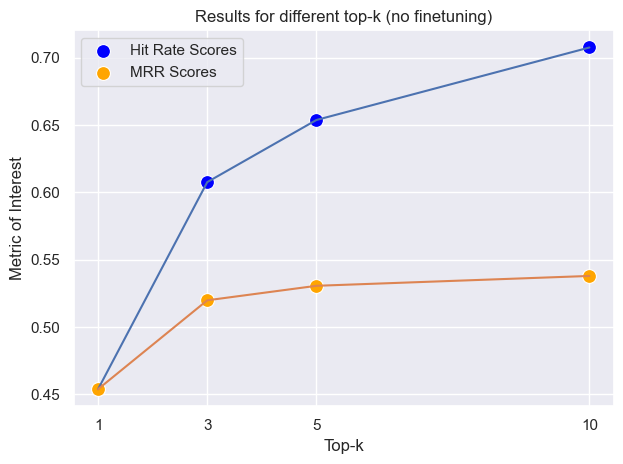

In [12]:
# plot results for different top-k is_hit and mrr
sns.lineplot(data=df_results_no_finetuning, x="top_k", y="is_hit")
sns.lineplot(data=df_results_no_finetuning, x="top_k", y="mrr")
sns.scatterplot(data=df_results_no_finetuning, x="top_k", y="is_hit", color="blue", s=100, label="Hit Rate Scores")
sns.scatterplot(data=df_results_no_finetuning, x="top_k", y="mrr", color="orange", s=100, label="MRR Scores")
plt.title("Results for different top-k (no finetuning)")
plt.xlabel("Top-k")
plt.ylabel("Metric of Interest")
plt.xticks(ticks=df_results_no_finetuning["top_k"].unique())
plt.grid(True)
plt.tight_layout()
plt.show()

# Embedding finetunig

In [13]:
from llama_index.finetuning import SentenceTransformersFinetuneEngine

finetune_engine = SentenceTransformersFinetuneEngine(
                                                    it_dataset,
                                                    model_id=model_name,
                                                    model_output_path="finetuned_model",
                                                    val_dataset=it_dataset,
                                                    )
#    epochs=1,
#    batch_size=16,
#    learning_rate=2e-5,
#    max_seq_length=128,

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


In [14]:
finetune_engine.finetune()

/opt/homebrew/Caskroom/miniconda/base/envs/agent/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100
26,No log,No log,0.600000,0.742308,0.796154,0.830769,0.600000,0.247436,0.159231,0.083077,0.600000,0.742308,0.796154,0.830769,0.718635,0.682344,0.686095
50,No log,No log,0.607692,0.769231,0.819231,0.850000,0.607692,0.256410,0.163846,0.085000,0.607692,0.769231,0.819231,0.850000,0.733621,0.695667,0.700110
52,No log,No log,0.611538,0.769231,0.823077,0.850000,0.611538,0.256410,0.164615,0.085000,0.611538,0.769231,0.823077,0.850000,0.735158,0.697718,0.702163


INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Information Retrieval Evaluation of the model on the  dataset in epoch 1.0 after 26 steps:
Information Retrieval Evaluation of the model on the  dataset in epoch 1.0 after 26 steps:
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Queries: 260
Queries: 260
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Corpus: 260

Corpus: 260

INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Score-Function: cosine
Score-Function: cosine
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Accuracy@1: 60.00%
Accuracy@1: 60.00%
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Accuracy@3: 74.23%
Accuracy@3: 74.23%
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Accuracy@5: 79.62%
Accuracy@5: 79.62%
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Accuracy@10: 83.08%
Accuracy@10: 83.08%
INFO:sentence_transfor

In [15]:
finetuned_embed_model = finetune_engine.get_finetuned_model()
finetuned_embed_model

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: finetuned_model
Load pretrained SentenceTransformer: finetuned_model


HuggingFaceEmbedding(model_name='finetuned_model', embed_batch_size=10, callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x104c36310>, num_workers=None, embeddings_cache=None, max_length=128, normalize=True, query_instruction=None, text_instruction=None, cache_folder=None, show_progress_bar=False)

In [16]:
import pandas as pd
from loguru import logger

df_results_finetuning = pd.DataFrame()

for top_k in [1, 3, 5, 10]:

    logger.info(f"Evaluating for top_k={top_k}")

    df_paraphrase_l12_results_it = evaluate(dataset=it_dataset, 
                                            embed_model=finetuned_embed_model,
                                            top_k=top_k, 
                                            verbose=True)
    df_results_finetuning_topk = dataframe_results(top_k, df_paraphrase_l12_results_it, finetuned=True)
    df_results_finetuning = pd.concat([df_results_finetuning, df_results_finetuning_topk], ignore_index=True)

df_results_finetuning

2025-07-14 18:12:06.131 | INFO     | __main__:<module>:8 - Evaluating for top_k=1


Some nodes are missing content, skipping them...


100%|██████████| 260/260 [00:03<00:00, 78.27it/s]
2025-07-14 18:12:10.616 | INFO     | __main__:<module>:8 - Evaluating for top_k=3


Some nodes are missing content, skipping them...


100%|██████████| 260/260 [00:03<00:00, 79.77it/s]
2025-07-14 18:12:15.044 | INFO     | __main__:<module>:8 - Evaluating for top_k=5


Some nodes are missing content, skipping them...


100%|██████████| 260/260 [00:03<00:00, 78.97it/s]
2025-07-14 18:12:19.496 | INFO     | __main__:<module>:8 - Evaluating for top_k=10


Some nodes are missing content, skipping them...


100%|██████████| 260/260 [00:03<00:00, 79.31it/s]


,model,finetuned,top_k,mrr,is_hit
0,paraphrase-multilingual-MiniLM-L12-v2,True,1,0.611538,0.611538
1,paraphrase-multilingual-MiniLM-L12-v2,True,3,0.685256,0.776923
2,paraphrase-multilingual-MiniLM-L12-v2,True,5,0.696603,0.826923
3,paraphrase-multilingual-MiniLM-L12-v2,True,10,0.700421,0.857692


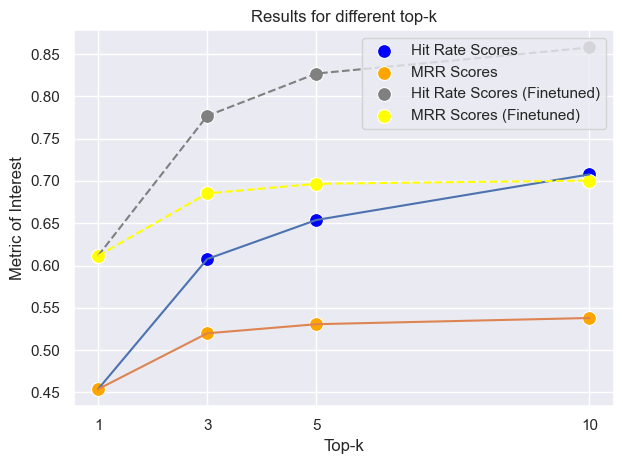

In [ ]:

sns.lineplot(data=df_results_no_finetuning, x="top_k", y="is_hit")
sns.lineplot(data=df_results_no_finetuning, x="top_k", y="mrr")
sns.scatterplot(data=df_results_no_finetuning, x="top_k", y="is_hit", color="blue", s=100, label="Hit Rate Scores")
sns.scatterplot(data=df_results_no_finetuning, x="top_k", y="mrr", color="orange", s=100, label="MRR Scores")

sns.lineplot(data=df_results_finetuning, x="top_k", y="is_hit", color="gray", linestyle='--')
sns.lineplot(data=df_results_finetuning, x="top_k", y="mrr", color="yellow", linestyle='--')
sns.scatterplot(data=df_results_finetuning, x="top_k", y="is_hit", color="gray", s=100, label="Hit Rate Scores (Finetuned)", marker='o')
sns.scatterplot(data=df_results_finetuning, x="top_k", y="mrr", color="yellow", s=100, label="MRR Scores (Finetuned)", marker='o')

plt.title("Results for different top-k")
plt.xlabel("Top-k")
plt.ylabel("Metric of Interest")
plt.xticks(ticks=df_results_no_finetuning["top_k"].unique())
plt.grid(True)
plt.tight_layout()
plt.show()